# KeyWordSpotting - LIVE DEMO

In [1]:
#Imports
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import Models #Our models
import LoadAndPreprocessDataset
#.......................

categories=['yes','no','up','down','left','right','on','off','stop','go']
#categories=['yes','no','up','down','left','right','on','off','stop','go','zero','one','two','three','four','five','six','seven','eight','nine','unknown']


## 1) Audio Input
### Recording from microphone

In [ ]:
sr = 16000
seconds = 10

myrec = sd.rec(int(sr*seconds), samplerate=sr, channels=1)
sd.wait()

np.save('LiveDemo/myrec.npy', myrec)

### Reading it from a numpy array

In [2]:
sr=16000
#myrec = np.load("LiveDemo/ONaudioclip.npy")
myrec = np.load("LiveDemo/myrec.npy")

### Reading it from a wav file

In [ ]:
myrec, sr = librosa.load("LiveDemo/audioclip.wav", sr=None)

### Audio Clip Informations

Sample rate =	16000 samples/s
Duration t =	10.0 s
Average intensity =	 0.0032758904


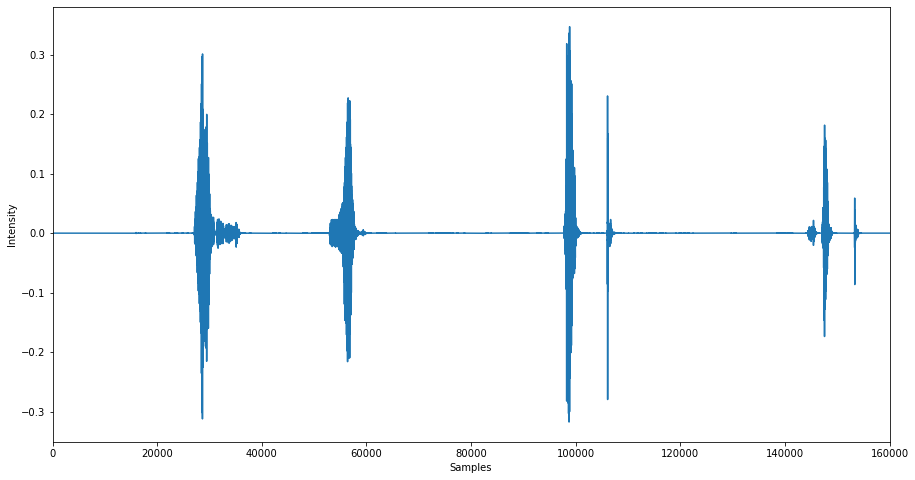

In [3]:
print("Sample rate =\t" + str(sr) + " samples/s")
print("Duration t =\t" + str(len(myrec) / sr) + " s")
print("Average intensity =\t",np.mean(np.abs(myrec)))

# Play it
play = True
if play:
    sd.play(myrec, sr)
    
# Plot
plt.figure(figsize=(15, 8))
plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(0, len(myrec))
plt.show()

## 2) Load Model

In [4]:
#Load Model
from tensorflow.keras.models import load_model
model_name="2020-07-24_16-57_DSConvModel"
model = load_model('models/'+model_name+'.h5')

## 3) ...

### Silince Filter

In [ ]:
#......

### Sliding Window
A 1 second window will slide left to right with a step of 1600 samples (100ms) in order to have 10 windows per second 



(160000, 1)
(160000, 1)
Number of windows: 19
Step: 8000
(19, 16000, 1)
(19, 1)
Window 0 Silence 2.2840499877929687e-05
Window 1 Silence 4.76531982421875e-05
Window 2 yes 0.011193147659301758
Window 3 yes 0.012027482986450195
Window 4 Silence 0.0008938522338867188
Window 5 no 0.0030438594818115233
Window 6 no 0.008534006118774414
Window 7 up 0.005554887771606445
Window 8 Silence 6.80694580078125e-05
Window 9 Silence 6.7047119140625e-05
Window 10 Silence 6.564712524414062e-05
Window 11 up 0.008090642929077149
Window 12 up 0.009074161529541016
Window 13 up 0.001048391342163086
Window 14 Silence 5.7180404663085936e-05
Window 15 Silence 5.5757522583007814e-05
Window 16 Silence 5.9078216552734375e-05
Window 17 stop 0.002489093780517578
Window 18 stop 0.002790924072265625


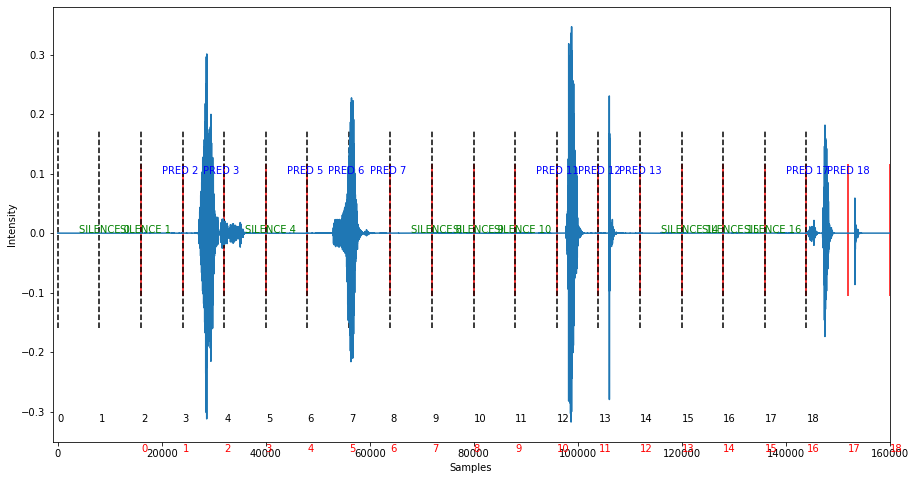

Average window 0.18218588829040527


'\nvoice=[] #indeces\nfor i in range(len(predictions)):\n    if predictions[i]!=-1:\n        voice.append(i)\n        plt.title(str(i)+" "+str(int(i*step))+"-"+str(int(i*step)+sr))\n        plt.figure(figsize=(5,2))\n        plt.plot(windows[i])\n        plt.xlabel("Samples")\n        plt.ylabel("Intensity")\n        plt.xlim(0, len(windows[i]))\n\nplt.show()'

In [5]:
print(myrec.shape)
if len(myrec.shape)<2: myrec=myrec[...,np.newaxis] # for the 1 sec audios
print(myrec.shape)

ws=2 #windows per second

step=int(sr/ws)
nwin=int((len(myrec)-sr)/step)+1 #number of windows
windows=np.empty((nwin,sr,1))
predictions=np.empty((nwin,1))

print("Number of windows:",nwin)
print("Step:",step)
print(windows.shape)
print(predictions.shape)

#divide in windows
for i in range(nwin):
    start=int(i*step)
    end=int(start+sr)
    windows[i]=myrec[start:end]

    
# Plot
plt.figure(figsize=(15, 8))
plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(-1000, len(myrec))


#prediction speed measure
import time
sStarts=[]
sEnds=[]

for i in range(nwin):
    start=int(i*step)
    plt.vlines(start, np.min(myrec)/2, np.max(myrec)/2, colors='k',linestyles='dashed')
    plt.vlines(start+sr, np.min(myrec)/3, np.max(myrec)/3, colors='r')
    plt.text(start, np.min(myrec), i)
    plt.text(start+sr, np.min(myrec)-0.05, i, color='red')
    
    
    
    #SILENCE FILTER
    if np.mean(np.abs(windows[i]))<(10**-3):
        predictions[i]=-1 #Silence
        plt.text(start+sr/4, 0, "SILENCE "+str(i), color='green')
        print("Window",i,"Silence",np.mean(np.abs(windows[i])))
    else:
        sStarts.append(time.time())
        
        a=windows[i]
        
        #preprocessing:         
        a=np.squeeze(a) #remove dimensions of length 1 (the last dimension)
        a=a[np.newaxis,...] #add dimension 1 at the beginning to indicate 1 example
        a=LoadAndPreprocessDataset.MFCC(a,n_mfcc=40)
        a=a[...,np.newaxis] #add dimension 1 at the end for CNN
        
        #no preprocessing:
        #a=a[np.newaxis,...]
        
        predictions[i]=np.argmax(model.predict(a),1)
        
        p=categories[int(predictions[i])]
        plt.text(start+sr/4, 0.1, "PRED "+str(i), color='blue')
        print("Window",i,p,np.mean(np.abs(windows[i])))
    
        sEnds.append(time.time())
    
plt.show()


#Prediction Speed measure
elapseds=[]
for i in range(len(sStarts)):
    elapseds.append(sEnds[i]-sStarts[i])

print("Average window",np.mean(elapseds))


'''
voice=[] #indeces
for i in range(len(predictions)):
    if predictions[i]!=-1:
        voice.append(i)
        plt.title(str(i)+" "+str(int(i*step))+"-"+str(int(i*step)+sr))
        plt.figure(figsize=(5,2))
        plt.plot(windows[i])
        plt.xlabel("Samples")
        plt.ylabel("Intensity")
        plt.xlim(0, len(windows[i]))

plt.show()'''


### Fusion Rule

In [6]:
#majority
'''
DFA
         -1           any = No silence
         ↓ ↑   any   ↓ ↑
    --->(S1)--------->(S2)
          ↑            |
          --------------
                -1 = Silence
'''
newPredictions=[]
predictions=list(predictions)
predictions+=[-1]*ws #add silence at the end (will be removed later)

s1=True #true=s1, false=s2
i=0
start=0
while i<len(predictions):
    if s1: #state 1
        if predictions[i]!=-1: #not silence
            start=i
            s1=False
        else: #silence
            newPredictions.append(-1)
        i+=1
    else: #state 2
        if predictions[i]!=-1: #not silence
            pass
        else: #silence
            end=i
            a=predictions[start:end]
            #calculate most common number in the list
            ht={}
            freq=0
            most_freq=-1
            for e in a:
                e=int(e)
                if e in ht:
                    ht[e]+=1
                    if ht[e]>freq:
                        most_freq=e
                        freq=ht[e]
                else: ht[e]=0
            newPredictions=newPredictions+[most_freq]*(end-start)
            #append silence
            newPredictions.append(-1)
            s1=True
        i+=1
#print(newPredictions)

# remove the silence added before
del newPredictions[-ws:]

for i in range(len(newPredictions)):
    if newPredictions[i]==-1: print(i,"Read:",predictions[i],newPredictions[i],"Silence")
    else: print(i,"Read:",predictions[i],newPredictions[i],categories[newPredictions[i]])

0 Read: [-1.] -1 Silence
1 Read: [-1.] -1 Silence
2 Read: [0.] 0 yes
3 Read: [0.] 0 yes
4 Read: [-1.] -1 Silence
5 Read: [1.] 1 no
6 Read: [1.] 1 no
7 Read: [2.] 1 no
8 Read: [-1.] -1 Silence
9 Read: [-1.] -1 Silence
10 Read: [-1.] -1 Silence
11 Read: [2.] 2 up
12 Read: [2.] 2 up
13 Read: [2.] 2 up
14 Read: [-1.] -1 Silence
15 Read: [-1.] -1 Silence
16 Read: [-1.] -1 Silence
17 Read: [8.] 8 stop
18 Read: [8.] 8 stop


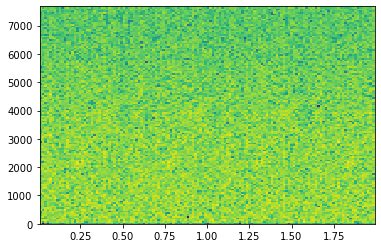

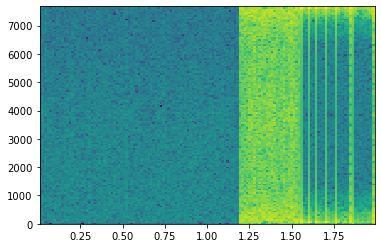

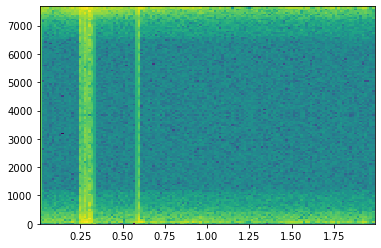

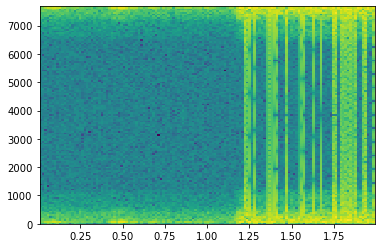

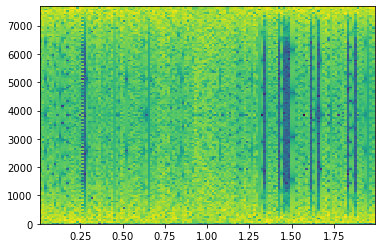

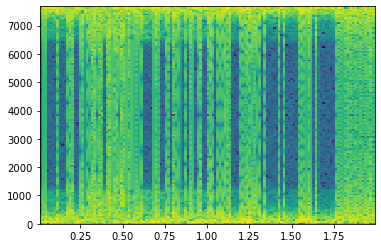

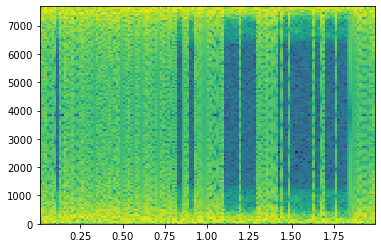

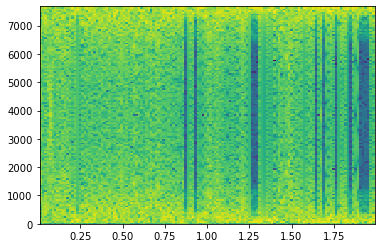

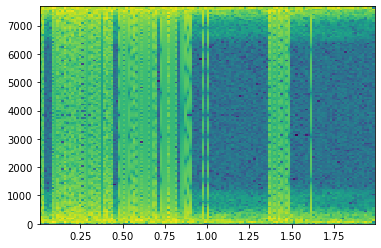

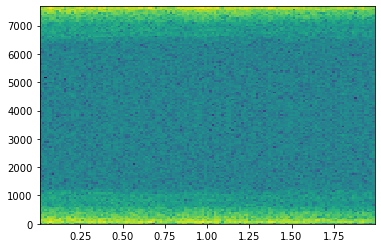

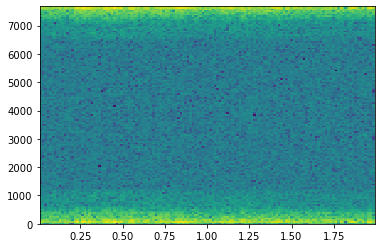

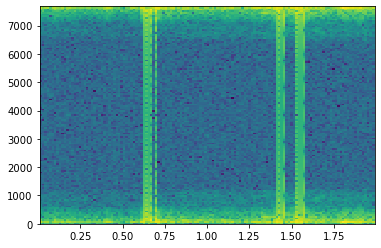

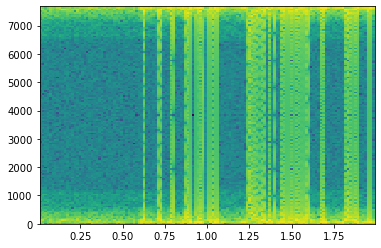

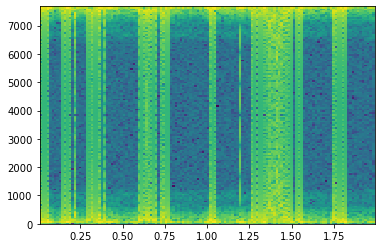

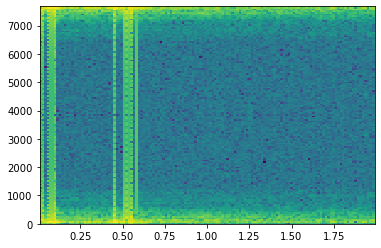

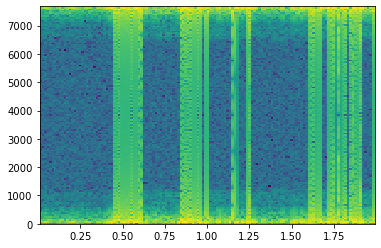

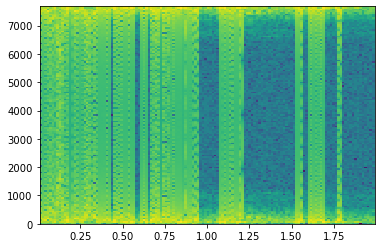

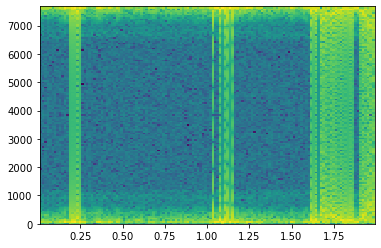

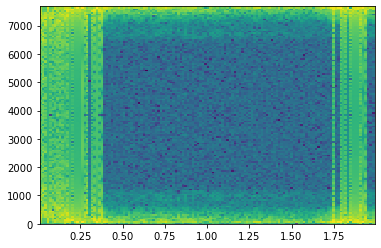

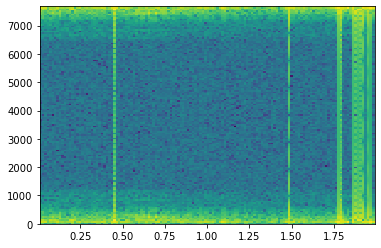

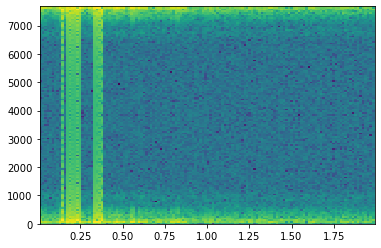

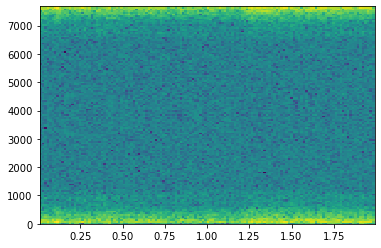

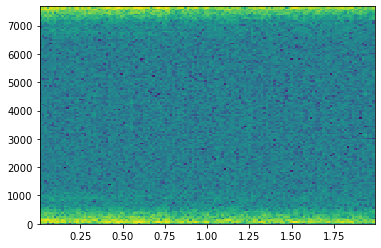

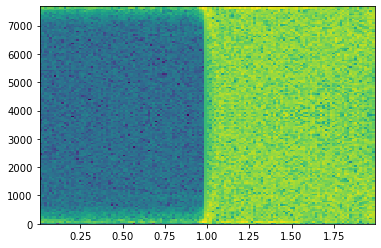

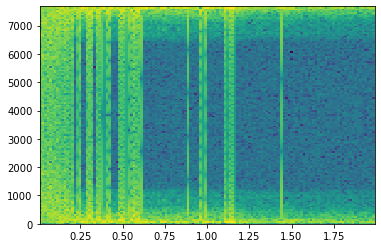

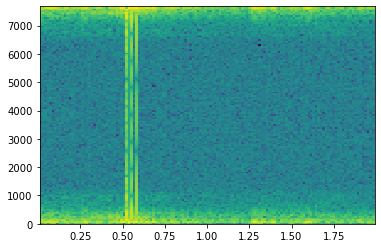

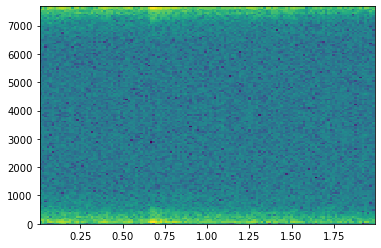

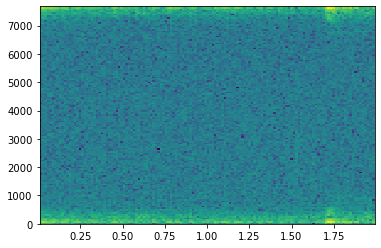

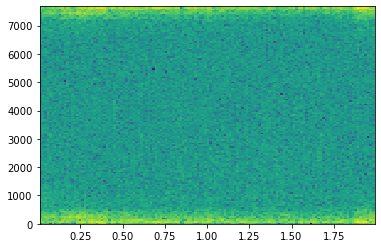

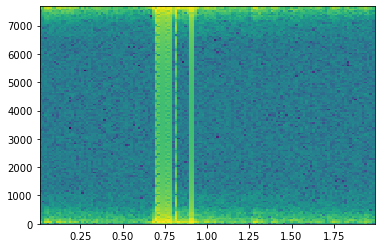

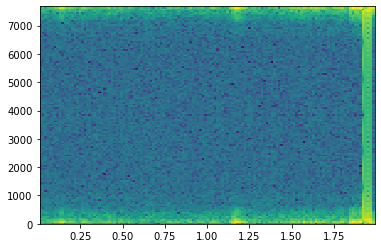

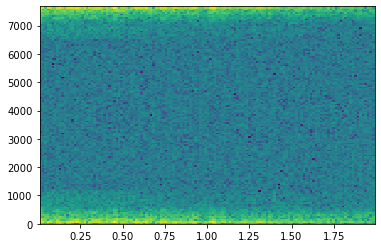

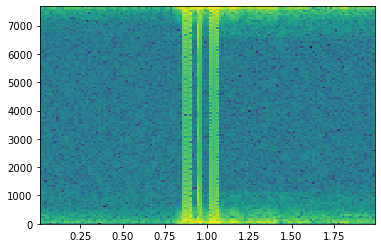

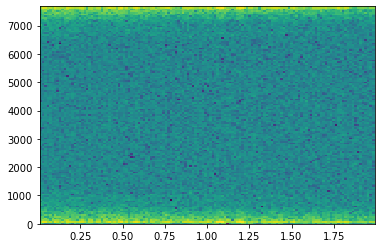

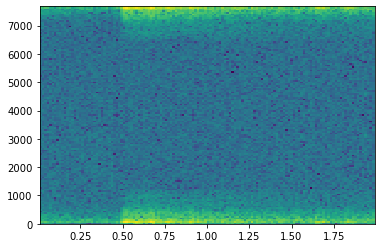

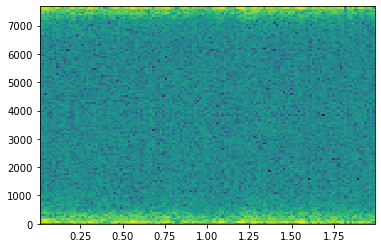

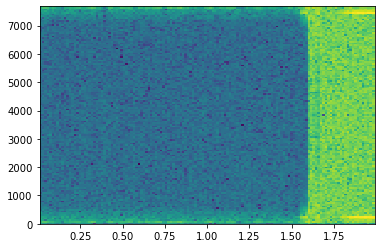

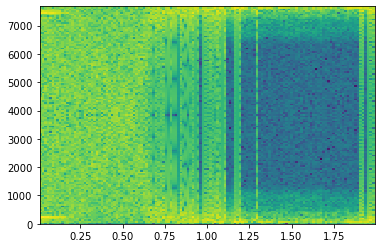

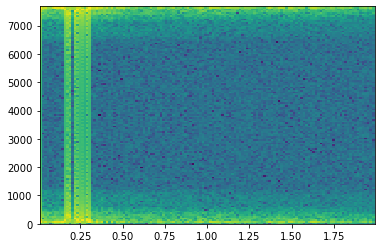

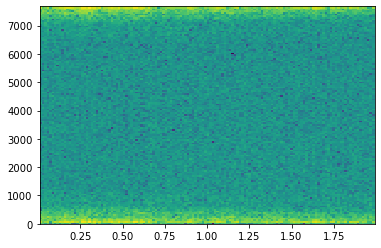

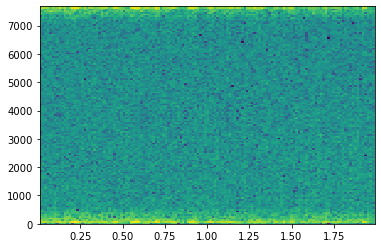

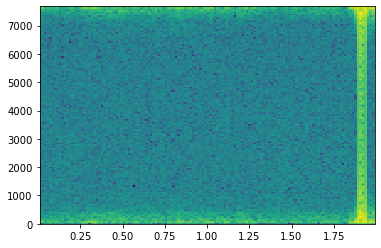

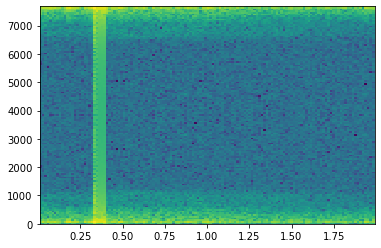

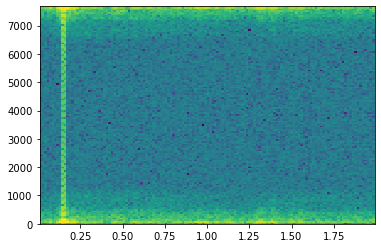

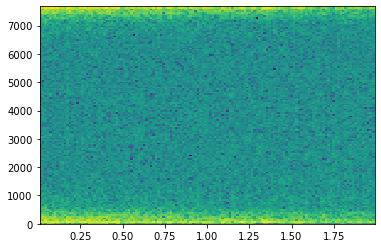

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [1]:

import pyaudio
import struct
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

mic = pyaudio.PyAudio()

INTERVAL = 0.32

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 48000
CHUNK = int(RATE * INTERVAL)

stream = mic.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, output=True, frames_per_buffer=CHUNK)

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

while True:
    data = stream.read(CHUNK, exception_on_overflow=False)
    data = np.frombuffer(data, dtype='b')
    f, t, Sxx = signal.spectrogram(data, fs=CHUNK)
    dBS = 10 * np.log10(Sxx)
    plt.clf()
    plt.pcolormesh(t, f, dBS)
    plt.pause(0.001)
    
stream.stop_stream()
stream.close()
mic.terminate()